# Q-Network 최적 경로 출력

---

In [ ]:
import os
import time
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
def one_hot(x):
    return np.identity(16)[x:x+1].astype(np.float32)

In [ ]:
#환경 변수
IDX_ACTION_UP = 0
IDX_ACTION_DOWN = 1
IDX_ACTION_RIGHT = 2
IDX_ACTION_LEFT = 3

STR_ACTION_UP = 'U'
STR_ACTION_DOWN = 'D'
STR_ACTION_RIGHT = 'R'
STR_ACTION_LEFT = 'L'

GOAL_STATE = 15

env = gym.make('FrozenLake-v0')

# Set Q-learning parameters
num_episodes = 5000
learning_rate = 0.1
dis = .99

# Input and output size based on the Env
input_size = env.observation_space.n
output_size = env.action_space.n

# weight
W = tf.Variable(tf.random.uniform([input_size, output_size], 0, 0.01), dtype=tf.float32)
# optimizer 
optimizer = tf.optimizers.SGD(learning_rate=learning_rate)

In [ ]:
# Q-table 시각화
def print_str_direct(q_value):
    cnt = 0
    while cnt < len(q_value):
        txt = ''
        for _ in range(4):
            # q-value가 실수인 경우 보완
            q = ''.join([str(int(round(e, 0))) for e in q_value[cnt]])
            if q == '1000':
                txt += STR_ACTION_UP
            elif q == '0100':
                txt += STR_ACTION_DOWN
            elif q == '0010':
                txt += STR_ACTION_RIGHT
            elif q == '0001':
                txt += STR_ACTION_LEFT
            else:
                txt += ' '
            txt += ' | '
            cnt += 1
        print(txt)    

In [ ]:
start_time = time.time()
rList = []

min_act = env.observation_space.n * env.action_space.n
optimal_W = []
optimal_q_value = []

for i in range(num_episodes):
    b_success = False   # goal에 도착한경우
    action_cnt = 0      # action 횟수 설정

    state = env.reset()
    rAll = 0
    done = False
    local_loss = []
    e = 1. / ((i / 50) + 10)
    
    while not done:
        q_value = tf.matmul(one_hot(state), W) 
        q_value = np.array(q_value.numpy())

        if np.random.rand(1) < e:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_value)

        state_next, reward, done, _ = env.step(action)

        if done:
            q_value[0, action] = reward
        else:
            q_score_next = tf.matmul(one_hot(state_next), W)  
            q_value[0, action] = reward + dis * np.max(q_score_next) 
        loss = lambda: tf.reduce_sum(input_tensor=tf.square(q_value - tf.matmul(one_hot(state), W)))

        optimizer.minimize(loss, var_list=W)
        
        rAll += reward
        action_cnt +=1
        state = state_next

        if state_next == GOAL_STATE:
            b_success = True

    rList.append(rAll)

    # 최단거리로 Goal간경우 q_value를 optimal value로 설정
    if b_success and action_cnt < min_act:            
        min_act = action_cnt
        optimal_W = W

656.9769451618195 seconds
Success rate: 0.553


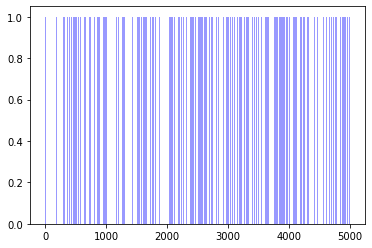

In [ ]:
print(f'{(time.time() - start_time)} seconds')
print("Success rate: " + str(sum(rList) / num_episodes))
plt.bar(range(len(rList)), rList, color='b', alpha=0.4)
plt.show()

- 최적 경로 출력

In [ ]:
def get_optimal_path(optimal_q_value):
    list_optimal_step = []
    optimal_step = 0
    optimal_path = []

    #q-value중 max값을 1로 변경
    qvalue_table = np.zeros([optimal_q_value.shape[0], optimal_q_value.shape[1]])

    for state, q_value in enumerate(optimal_q_value):
        q_max = np.amax(q_value)  # q_value array의 최댓값 반환
        indices = np.nonzero(q_value == q_max)[0]
        qvalue_table[state, indices[0]] = 1
        state += 1

    #print(qvalue_table)

    for state, q_value in enumerate(qvalue_table):
        index = q_value.argmax()

        if optimal_step == state : # 최단 경로 위에 있는 state에 대해 최적경로step을 지정한다.
            list_optimal_step.append(optimal_step)

            if optimal_step == GOAL_STATE:
                q_value = [0,0,0,0]
            else:   
                if index == IDX_ACTION_UP :
                    optimal_step -= 4
                elif index == IDX_ACTION_DOWN :
                    optimal_step += 4
                elif index == IDX_ACTION_RIGHT :
                    optimal_step += 1
                elif index == IDX_ACTION_LEFT :
                    optimal_step -= 1
                else: 
                    pass
        else:
            q_value = [0,0,0,0]
        
        optimal_path.append(list(map(int,q_value)))

    #print(list_optimal_step)
    #print(optimal_path)

    if optimal_step != GOAL_STATE:
        print("Agent can't find optimal path.")
    return optimal_path

In [ ]:
optimal_W

<tf.Variable 'Variable:0' shape=(16, 4) dtype=float32, numpy=
array([[4.0580216e-01, 3.2390481e-01, 2.9369134e-01, 3.2419205e-01],
       [1.8227494e-01, 2.6723081e-01, 2.5923607e-01, 3.2316986e-01],
       [2.4382497e-01, 2.5963655e-01, 2.4983278e-01, 2.8213221e-01],
       [2.2618996e-01, 1.9795075e-01, 1.5135767e-01, 2.6163682e-01],
       [4.4303235e-01, 3.0679798e-01, 1.9065730e-01, 1.8682507e-01],
       [3.3919907e-03, 3.9888239e-03, 1.8386745e-03, 9.8750340e-03],
       [3.9356995e-01, 1.6061597e-01, 8.8367045e-02, 6.5831997e-02],
       [5.0370526e-03, 8.2054362e-03, 6.0477243e-03, 1.1861157e-03],
       [3.2245511e-01, 3.5307741e-01, 3.3513162e-01, 5.0553268e-01],
       [3.1363946e-01, 5.8030903e-01, 3.4519148e-01, 4.0205607e-01],
       [5.6709683e-01, 3.2785010e-01, 1.4580201e-01, 2.5536975e-01],
       [4.0074098e-03, 9.9304384e-03, 2.9873252e-03, 9.3891686e-03],
       [7.3160644e-04, 1.4047384e-04, 5.7265353e-03, 6.9081243e-03],
       [3.4429336e-01, 4.3062094e-01, 6.6

In [ ]:
#최종 route 출력
optimal_path = get_optimal_path(optimal_W)
print_str_direct(optimal_path)

Agent can't find optimal path.
U |   |   |   | 
  |   |   |   | 
  |   |   |   | 
  |   |   |   | 
